<a href="https://colab.research.google.com/github/bmarzban/CVSmodels/blob/main/PPG_Biostrap_pyheart_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [267]:
pip install heartpy

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.


In [268]:
import numpy as np
from numpy import diff
import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks

#df = pd.read_csv('raw_ppg.csv')
import os
from google.colab import drive
from google.colab import files  
#drive.mount('/drive')
mypath = "/content/drive/MyDrive/Daxor/PycharmProjects/PPGProject"
os.chdir('/content/drive/MyDrive/Daxor/PycharmProjects/PPGProject')
## dataset = pd.read_csv("data.csv")
#acc_data = pd.read_csv("20211101.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20211101.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211101.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211101.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20211104.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20211104.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211104.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211104.biometrics.csv") #Read data from CSV datafile

acc_data = pd.read_csv("20220104.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20220104.PPG.csv") #Read data from CSV datafile
PPG_data = pd.read_csv("20220104.csv") #Read data from CSV datafile
biometrics_data = pd.read_csv("20220104.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20211228.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20211228.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211228.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211228.biometrics.csv") #Read data from CSV datafile

#acc_data = pd.read_csv("20211108.wristband_accel.csv") #Read data from CSV datafile
##PPG_data = pd.read_csv("20211228.PPG.csv") #Read data from CSV datafile
#PPG_data = pd.read_csv("20211108.csv") #Read data from CSV datafile
#biometrics_data = pd.read_csv("20211108.biometrics.csv") #Read data from CSV datafile





There seems to be intermittent sections of PPG dotted between non-signals (periods where the sensor was not recording).

For now let's slice the first signal section and see what's up. Later on I'll show you how to exclude non-signal sections automatically.

Now we need to know the sampling rate
The sampling rate is the one measure to rule them all. It is used to compute all others.

HeartPy has several ways of getting the sample rate from timer columns. Let's look at the format of the timer column to see what we're working with.

# So, the format seems to be up to ns percision in time'

HeartPy comes with a datetime function that can work with date- and time-strings called get_samplerate_datetime. Check the help to see how it works:

In [269]:

# The PPG data time vector is the unit of the nano second (ns)
nsec_to_sec = 1e-9;
msec_to_sec = 1e-3;
sec_to_min = 1/60;
# The accelartion data time vector is the unit of the mili second (ms)

# extracting out the sampling frequency in both accelartion data and ppg data

# sampling rate is in Hz, meaning how often we read the data or how many times we read a data on second
# Low pas filter, highpass filter, we need some, or band width filter we need some sampling rate/frequency here but this is how it works:
PPG_time = PPG_data.ts - PPG_data.ts[0]
PPG_sample_freq =1/ np.mean(diff(PPG_time[1:1700])*nsec_to_sec)
print('PPG sampling rate:')
print(PPG_sample_freq)

acc_time = acc_data.ts - acc_data.ts[0]
acc_sample_freq =1/ np.mean(diff(acc_time[1:100])*msec_to_sec)
print('acc sampling rate:')
print(acc_sample_freq)

PPG sampling rate:
42.00000142800005
acc sampling rate:
10.0


In [270]:


print('PPG sampling rate is: %.3f Hz' %PPG_sample_freq)
print('ACC sampling rate is: %.3f Hz' %acc_sample_freq)

PPG sampling rate is: 42.000 Hz
ACC sampling rate is: 10.000 Hz


That's pretty low.
The sample rate is quite low but to conserve power this is what many smart watches work with. For determining the BPM this is just fine, but any heart rate variability (HRV) measures are likely not going to be super accurate. Depending on your needs it may still be fine, though.

A second consideration with sampling rate is whether it's stable or not. Many devices including smart watches do many things at once. They run an OS that has other tasks besides measuring heart rate, so when measuring at 10Hz, the OS might not be ready exactly every 100ms to get a measurement. As such, the sampling rate might vary. Let's visualise this.



You could of course interpolate and resample the signal so that it has an exact sampling rate but the effects on computed measures are likely minimal. For now let's just continue on.

The first thing to note is that amplitude varies dramatically. Let's run it through a bandpass filter and take out all frequencies that definitely are not heart rate.

We'll take out frequencies below 0.7Hz (42 BPM) and above 3.5 Hz (210 BPM).

Still low quality but at least the heart rate is quite visible now!


Let's use a for loop and filter all the data segments


In [271]:

time = ((PPG_time)*sec_to_min*nsec_to_sec).to_numpy()
ir_filt = PPG_data.ir_filt.to_numpy()
red_filt = PPG_data.red_filt.to_numpy()
red_raw = PPG_data.red.to_numpy()
ir_raw = PPG_data.ir.to_numpy()
#missing pieces! Let's replace
red = np.nan_to_num(red_raw)
ir = np.nan_to_num(ir_raw)
# peak finding


**writing a simple loop to mark the step rise in the time, so basically the idea is the same as the peak finder but here we just compare the k element with elements k-1 and k-2 and not k+1 ... in a for loop**


In [272]:
# writing a simple code to mark the step rise in the time
# so basically the idea is the same as the peak finder but here we just compare the k element with elements k-1 and k-2 and not k+1 ... in a for loop
length_vec = np.arange(2, len(time)-1, 1)
length_vec = np.arange(2, len(time), 1)

recording_episode_counts = 0
#time_jump_threshold = 0.00039682; # units in minute since we converted the time to minute earlier today
time_jump_threshold = 0.01;
collect_start_idx =[]
for k in length_vec:
  if (time[k]> time[k-1] and (time[k]- time[k-1]) >time_jump_threshold) :
   # print(k)
    recording_episode_counts = recording_episode_counts + 1

recording_episode_counts_total = recording_episode_counts
collect_start_idx = np.zeros(recording_episode_counts) 
recording_episode_counts = 0

for k in length_vec:
  if (time[k]> time[k-1] and (time[k]- time[k-1]) >time_jump_threshold) :
    #print(k)
    recording_episode_counts = recording_episode_counts + 1
    collect_start_idx [recording_episode_counts-1] = k

#print(recording_episode_counts)
#print(collect_start_idx)
#print(diff(collect_start_idx))

**identifying jumps in time vector**


<class 'numpy.ndarray'>


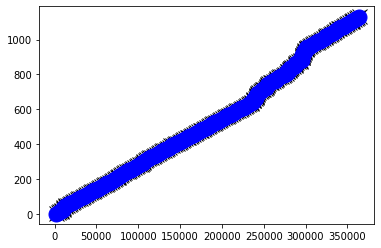

In [273]:
plt.figure()
plt.plot( np.arange(0, len(time),1),time,'xy')
print(type(collect_start_idx))

collect_start_idx = collect_start_idx.astype(int)

#print(time[collect_start_idx])
plt.plot(collect_start_idx,time[collect_start_idx],'x',color='black', markersize=15, linewidth=5)
#plt.xlim([350000,364000])
#plt.ylim([0,80])
# plotting the end times
collect_end_idx = collect_start_idx - 1
plt.plot(collect_start_idx,time[collect_end_idx],'o',color='blue', markersize=15, linewidth=10)


# identifying jumps in time vector


Finding the peak and extracting the HR beats

So here is why I need to do a segment separation If you will. It means that apparently, and it need to be checked, but if our recording segment is short the filtering process fails. That means we need to exclude that from our filtering. So the way I do that I would say if the segment length is smaller than like 20 or something, we just exclude that. 
So the sampling rate is a


[0.]
1934
363781
363837
227
227


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


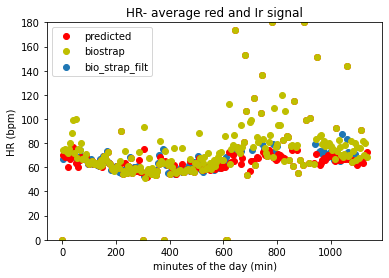

In [274]:
# so the next thing is actually plotting the HR versus time and compare that with the plot from people in biostrap
  #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.

#time_intervals = time[collect_end_idx[1:]] - time[collect_start_idx[:-1]]
#print(time_intervals)
#print(len(time_intervals))
#print(diff(time[collect_end_idx]))
#print(len(diff(time[collect_end_idx])))
num_of_recording_segments = np.arange(1, recording_episode_counts_total+1, 1)
#num_of_recording_segments = np.arange(1, 40, 1)

if collect_start_idx[0] != 0:
   collect_start_idx =np.append(0,collect_start_idx)

#HR_ave = np.zeros(recording_episode_counts_total)
#filtered_seg=[]
#filtered = []
#red_filt_pyheart = np.zeros(len(red))
red_filt_pyheart =np.zeros(1)
print(red_filt_pyheart)
for j in num_of_recording_segments:
  if collect_start_idx[j]-collect_start_idx[j-1] < 20:
     filtered_seg = np.zeros(collect_start_idx[j]-collect_start_idx[j-1])
  else:
     filtered_seg = hp.filter_signal(red[collect_start_idx[j-1]:collect_start_idx[j]], [0.7, 3.5], sample_rate=PPG_sample_freq, 
                            order=3, filtertype='bandpass')
 
  red_filt_pyheart= np.append(red_filt_pyheart,filtered_seg)

print(len(filtered_seg))
print(len(red_filt_pyheart))
print(len(red))

HR_ave = np.zeros(recording_episode_counts_total+1)
#print(time_intervals)
for j in num_of_recording_segments:
  #peaks, _ = find_peaks(red_filt[collect_start_idx[m-1]:collect_start_idx[m]], height=0)
  #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
  
  peaks, _ = find_peaks((red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]] + red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]])/2, height=0,distance = 20)
  peaks2, _ = find_peaks((red_filt[collect_start_idx[j-1]:collect_start_idx[j]] + red_filt[collect_start_idx[j-1]:collect_start_idx[j]])/2, height=0,distance = 20)


# extracting the HR beat:
  hr_interval = np.diff(time[peaks])
  hr_interval_mean = np.mean(hr_interval)
  #print(time[peaks[-1]]-time[peaks[0]])
  #print(m)
  if len(peaks) == 0:
    continue
  time_interval_in_min = (time[peaks[-1]]-time[peaks[0]] )
  #print(time[peaks[-1]])
  #print(time[peaks[0]])

  HR_ave [j] = len(peaks)/time_interval_in_min;
print(len(HR_ave))
#print(HR_ave)
plt.figure()
plt.plot(time[collect_start_idx],HR_ave, 'or')
plt.title("HR- average red and Ir signal") #The title of our plot
# plotting the data
# replacing the nan data with zero 
spo2 = biometrics_data.spo2.replace(0,np.nan)
HR = biometrics_data.bpm.replace(0,np.nan)

HRnp = HR.to_numpy()

plt.scatter(biometrics_data.minute_of_day,HRnp)
plt.xlabel('minutes of the day (min)')
plt.ylabel('HR (bpm)')
plt.ylim([0,180])
#plt.xlim([200, 400])
for m in num_of_recording_segments:
  #peaks, _ = find_peaks(red_filt[collect_start_idx[m-1]:collect_start_idx[m]], height=0)
  #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
  
  peaks2, _ = find_peaks((red_filt[collect_start_idx[m-1]:collect_start_idx[m]] + red_filt[collect_start_idx[m-1]:collect_start_idx[m]])/2, height=0)


# extracting the HR beat:
  hr_interval = np.diff(time[peaks2])
  hr_interval_mean = np.mean(hr_interval)
  #print(time[peaks[-1]]-time[peaks[0]])
  #print(m)
  if len(peaks2) == 0:
    continue
  time_interval_in_min = (time[peaks2[-1]]-time[peaks2[0]] )
  #print(time[peaks[-1]])
  #print(time[peaks[0]])

  HR_ave [m] = len(peaks2)/time_interval_in_min;
print(len(HR_ave))
plt.plot(time[collect_start_idx],HR_ave, 'oy')
plt.legend([ 'predicted', 'biostrap','bio_strap_filt'])

plt.show()

In the above the difference between the length signal of the red signal and the filtered appended segment by segment raw signal is that the last segment is not counted in our simulations
 

I need to repeat the above calculation with the distance peak functiona and with the negative sign of the filter which is the true signal:


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


227
227


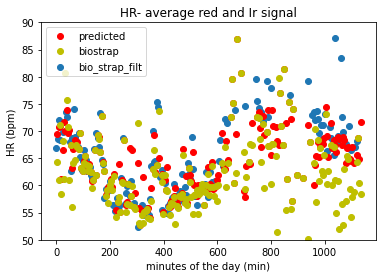

In [275]:
# so the next thing is actually plotting the HR versus time and compare that with the plot from people in biostrap
  #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.

num_of_recording_segments = np.arange(1, recording_episode_counts_total+1, 1)
if collect_start_idx[0] != 0:
   collect_start_idx =np.append(0,collect_start_idx)

red_filt_pyheart =np.zeros(1)
#red_filt_pyheart =[]
for j in num_of_recording_segments:
  if collect_start_idx[j]-collect_start_idx[j-1] < 20:
     filtered_seg = np.zeros(collect_start_idx[j]-collect_start_idx[j-1])
  else:
     filtered_seg = hp.filter_signal(red[collect_start_idx[j-1]:collect_start_idx[j]], [0.7, 3.5], sample_rate=PPG_sample_freq, 
                            order=3, filtertype='bandpass')
 
  red_filt_pyheart= np.append(red_filt_pyheart,filtered_seg)

red_filt_pyheart= -red_filt_pyheart
red_filt= -red_filt
HR_ave = np.zeros(recording_episode_counts_total+1)
for j in num_of_recording_segments:
  #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
  
  peaks, _ = find_peaks((red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]] + red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]])/2, height=0,distance =20)
  peaks2, _ = find_peaks((red_filt[collect_start_idx[j-1]:collect_start_idx[j]] + red_filt[collect_start_idx[j-1]:collect_start_idx[j]])/2, height=0,distance =20)


# extracting the HR beat:
  hr_interval = np.diff(time[peaks])
  hr_interval_mean = np.mean(hr_interval)
  #print(time[peaks[-1]]-time[peaks[0]])
  #print(m)
  if len(peaks) == 0:
    continue
  time_interval_in_min = (time[peaks[-1]]-time[peaks[0]] )
  #print(time[peaks[-1]])
  #print(time[peaks[0]])

  HR_ave [j] = len(peaks)/time_interval_in_min;
print(len(HR_ave))
#print(HR_ave)
plt.figure()
plt.plot(time[collect_start_idx],HR_ave, 'or')
plt.title("HR- average red and Ir signal") #The title of our plot
# plotting the data
# replacing the nan data with zero 
spo2 = biometrics_data.spo2.replace(0,np.nan)
HR = biometrics_data.bpm.replace(0,np.nan)

HRnp = HR.to_numpy()

plt.scatter(biometrics_data.minute_of_day,HRnp)
plt.xlabel('minutes of the day (min)')
plt.ylabel('HR (bpm)')
plt.ylim([50,90])
#plt.xlim([200, 400])
for m in num_of_recording_segments:
  #peaks, _ = find_peaks(red_filt[collect_start_idx[m-1]:collect_start_idx[m]], height=0)
  #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
  
  peaks2, _ = find_peaks((red_filt[collect_start_idx[m-1]:collect_start_idx[m]] + red_filt[collect_start_idx[m-1]:collect_start_idx[m]])/2, height=0,distance =20)


# extracting the HR beat:
  hr_interval = np.diff(time[peaks2])
  hr_interval_mean = np.mean(hr_interval)
  #print(time[peaks[-1]]-time[peaks[0]])
  #print(m)
  if len(peaks2) == 0:
    continue
  time_interval_in_min = (time[peaks2[-1]]-time[peaks2[0]] )
 
  HR_ave [m] = len(peaks2)/time_interval_in_min;
print(len(HR_ave))
plt.plot(time[collect_start_idx],HR_ave, 'oy')
plt.legend([ 'predicted', 'biostrap','bio_strap_filt'])

plt.show()

227


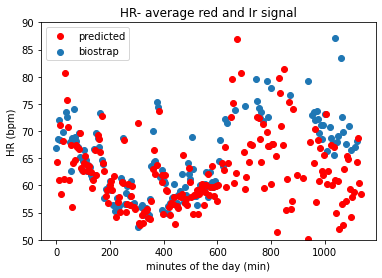

In [276]:
print(len(HR_ave))
#print(HR_ave)
plt.figure()
plt.plot(time[collect_start_idx],HR_ave, 'or')
plt.title("HR- average red and Ir signal") #The title of our plot
# plotting the data
# replacing the nan data with zero 
spo2 = biometrics_data.spo2.replace(0,np.nan)
HR = biometrics_data.bpm.replace(0,np.nan)

HRnp = HR.to_numpy()

plt.scatter(biometrics_data.minute_of_day,HRnp)
plt.xlabel('minutes of the day (min)')
plt.ylabel('HR (bpm)')
plt.ylim([50,90])
#plt.xlim([200, 400])

plt.legend([ 'predicted', 'biostrap'])

plt.show()



That seems a reasonable result. By far the most peaks are marked correctly, and most peaksin noisy sections (low confidence) are simply rejected.
clean_rr uses by default quotient-filtering, which is a bit aggressive.

You can set 'iqr' or 'z-score' with the clean_rr_method flag.

Finally let's look at a way to extract signal section and exclude non-signal sections automatically.

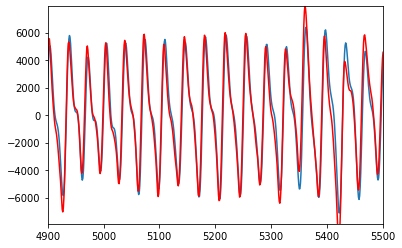

In [277]:
plt.figure()
plt.plot(red_filt_pyheart)
plt.plot(red_filt,'r')
plt.xlim([41900,42500])
plt.xlim([4900,5500])
plt.ylim([-7900,7900])


plt.show()

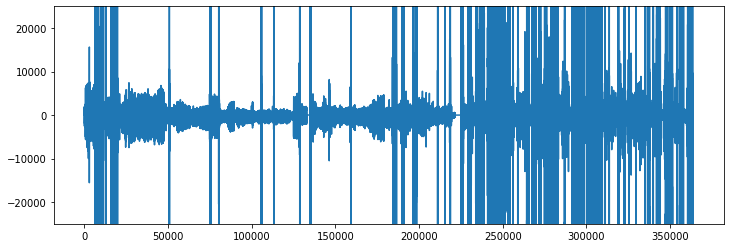

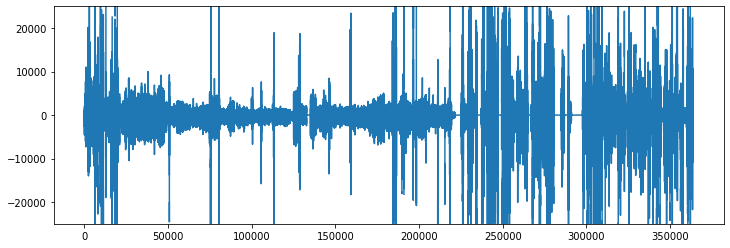

In [278]:
data = red_filt_pyheart
plt.figure(figsize=(12,4))
plt.plot(data)
plt.ylim([-25000,25000])
plt.show()

#and zoom in a bit
plt.figure(figsize=(12,4))
plt.plot(red_filt)
plt.ylim([-25000,25000])

plt.show()


# New Section

bpm: 72.229299
ibi: 830.687831
sdnn: 150.519569
sdsd: 140.004027
rmssd: 198.611012
pnn20: 0.916667
pnn50: 0.541667
hr_mad: 71.428571
sd1: 140.432185
sd2: 143.263037
s: 63204.889910
sd1/sd2: 0.980240
breathingrate: 0.266667
bpm: 70.552764
ibi: 850.427350
sdnn: 129.172465
sdsd: 122.080255
rmssd: 155.447201
pnn20: 0.875000
pnn50: 0.375000
hr_mad: 47.619048
sd1: 109.268937
sd2: 79.560152
s: 27311.288930
sd1/sd2: 1.373413
breathingrate: 0.300000
bpm: 70.451613
ibi: 851.648352
sdnn: 128.478109
sdsd: 118.280791
rmssd: 165.842076
pnn20: 0.823529
pnn50: 0.558824
hr_mad: 43.650794
sd1: 115.349170
sd2: 103.273841
s: 37424.385478
sd1/sd2: 1.116925
breathingrate: 0.233333
bpm: 71.295734
ibi: 841.565079
sdnn: 140.146239
sdsd: 125.703451
rmssd: 188.935382
pnn20: 0.882353
pnn50: 0.705882
hr_mad: 82.333333
sd1: 130.428867
sd2: 119.657203
s: 49030.062034
sd1/sd2: 1.090021
breathingrate: 0.198153


<Figure size 864x288 with 0 Axes>

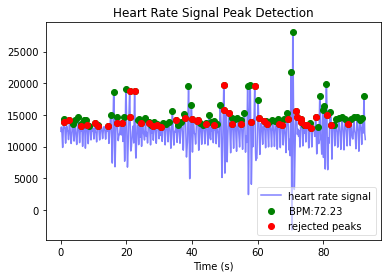

<Figure size 864x288 with 0 Axes>

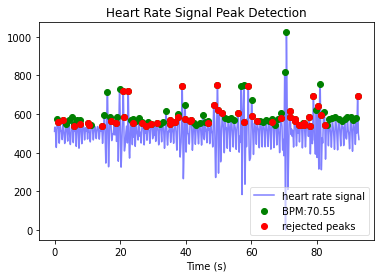

<Figure size 864x288 with 0 Axes>

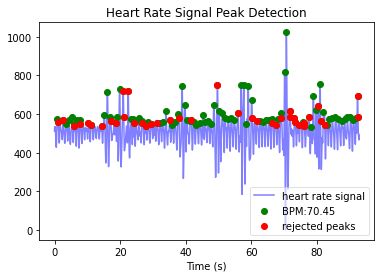

<Figure size 864x288 with 0 Axes>

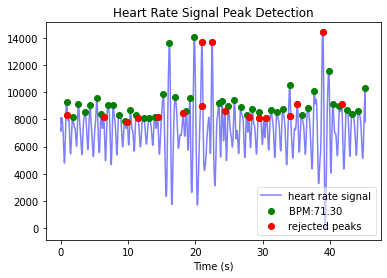

In [279]:
#run analysis
from scipy.signal import resample

wd, m = hp.process((data[0:3900]), 42)


#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

## trying to 
wd, m = hp.process(hp.scale_data(data[0:3900]), 42)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

## trying to resample the data
resampled_data = resample(data[0:3900], len(data[0:3900]) * 3)
#resampled_data = resample(data, len(data) * 3)

wd, m = hp.process(hp.scale_data(resampled_data), 3*42)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

    ## trying to resample the data
#resampled_data = resample(data[5000:5500], len(data[5000:5500]) * 4)
resampled_data = resample(data[0:1900], len(data[0:1900]) * 4)

#resampled_data = resample(data, len(data) * 4)

#wd, m = hp.process(resampled_data, 4*42)
#wd, m = hp.process(resampled_data, 4*42, bpmmin=-1, bpmmax=200,reject_segmentwise=False)
wd, m = hp.process(resampled_data, 4*42, bpmmin=40, bpmmax=180,reject_segmentwise=False, high_precision = True)

#wd, m = hp.process_segmentwise(resampled_data, 4*42, segment_width=120, segment_overlap=0.5, mode = 'fast', replace_outliers = True)
#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)
#plt.xlim([6270,6280])

#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))


nonlinear poincare measures:
sd1: 130.428867
sd2: 119.657203
s: 49030.062034
sd1/sd2: 1.090021


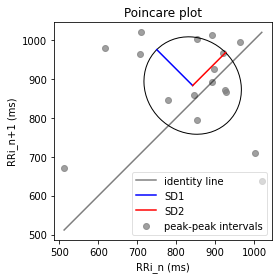

In [280]:
hp.plot_poincare(wd, m)

#print poincare measures
poincare_measures = ['sd1', 'sd2', 's', 'sd1/sd2']
print('\nnonlinear poincare measures:')
for measure in poincare_measures:
    print('%s: %f' %(measure, m[measure]))

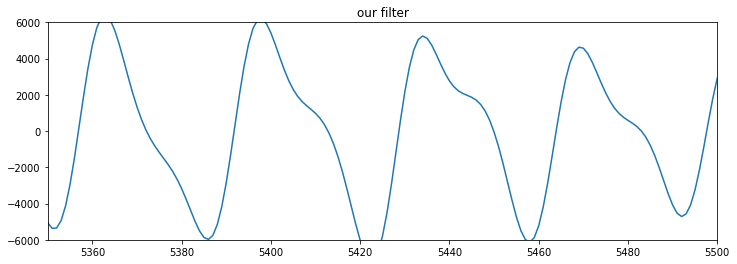

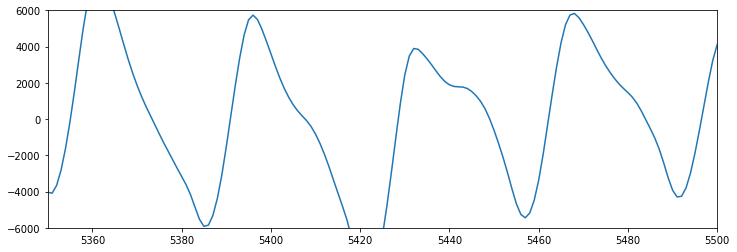

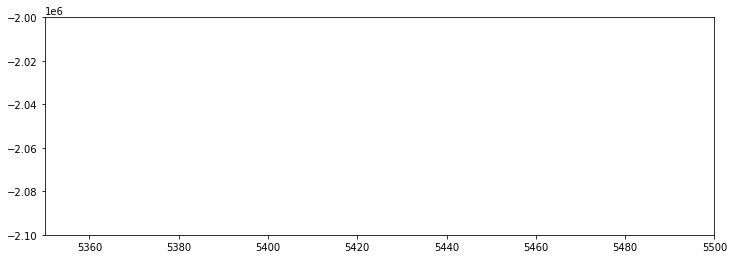

In [281]:
#data = hp.get_data('e0110.csv')
data = red_filt_pyheart
plt.figure(figsize=(12,4))
plt.plot(data)
plt.xlim([5350,5500])
plt.ylim([-6000,6000])
plt.title('our filter')
plt.show()

#and zoom in a bit
plt.figure(figsize=(12,4))
plt.plot(red_filt)
plt.xlim([5350,5500])
plt.ylim([-6000,6000])

plt.show()

#and zoom in a bit
plt.figure(figsize=(12,4))
plt.plot(red,'ro')
plt.xlim([5350,5500])
plt.ylim([-2100000,-2000000])

plt.show()


Okay it’s done and now let’s move to next target. So I have signal that can predict the HR for all times, I can just rplace zero HR with nan for plotting purposes ,
Now let’s build the DQM
DQM1 is the length of the recordings. Recordings less than 10  seconds gonna be excluded an reported as bad quality well the recording  sampling rate is 42 Hz, therefore we have the following number of sample/threshold for short recordings, length of the diff less than 42*10 = 420 we will call it off the chart
We figured out what is DQM1 is let’s just make it happen
 


We aslo do the calculations for both signals


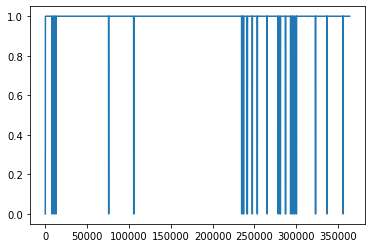

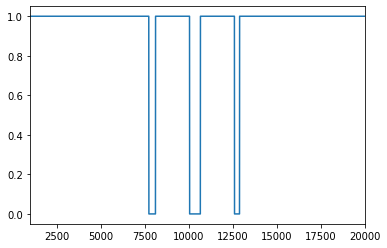

(array([     0,   7737,   7738, ..., 356042, 356043, 356044]),)

In [282]:
# this is the veru first Data Quality Metric (DQM) which is the lenght of eache recording segment
# if it's less than 10 second, we will ignore it and treat it as not recorded signal

PPG_sample_freq = PPG_sample_freq.astype(int)

segment_length_threshold = 10*PPG_sample_freq
#DQM_signal =[]
DQM_signal = np.zeros(1)
for j in num_of_recording_segments:
  if collect_start_idx[j]-collect_start_idx[j-1] < segment_length_threshold:
     DQM_segment_temp = np.zeros(collect_start_idx[j]-collect_start_idx[j-1])
  else:
     DQM_segment_temp = np.ones(collect_start_idx[j]-collect_start_idx[j-1])

  DQM_signal= np.append(DQM_signal,DQM_segment_temp)

plt.figure()
plt.plot(DQM_signal)
plt.show()

# zooming to the first recordings
plt.figure()
plt.plot(DQM_signal)
plt.xlim([1000,20000])
plt.show()

np.where(DQM_signal<1)
#now let's use this DQM into our HR prediction and then we will add more DQM_criteria

after obtaining the DQM I can simply adjust every signal by rejecting/ignoring the low DQM. with the following metrics. 
I can use the element wise product of the signal with the DQM and not the dot product.

- I can also go ahead and calculate the slope right after the peak for every segment. 
- another thing I can add is actually reject the segments that have high volatility:
I can come up with a variable and a threshold for that. (it could be a normalized version nd has to distinguish between the following signals )

- I can do an envelope kind of things for each segment and comeup with envelope variation metriac and reject that signal!
- Another thing I can do is actually choose a middle window or a window in each signal that has lower envelope variation:
For instance every segment is divided to 3 or 4 slice I can use the best slice for HR or SPO2 or extraction of slope,


for the envelop of each segment, we just find the peak of the signal and the the reverse signal(signal multiplied * -1) which is basically the mean of the signal

We make a function to plot the segments by giving the segment numbers


60.431656730943054
Heart rate for the segment


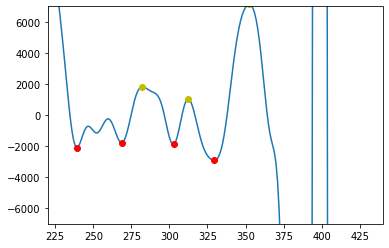

In [322]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
seg_number = 61
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')
plt.xlim([220,440])
plt.ylim([-7000,7000])
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

plotting the upper enevelope and lower envelope with a dashline 

(-7000.0, 7000.0)

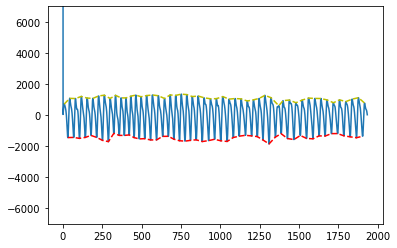

In [284]:
# plotting the upper envelope and lowe envelope
plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'--y')
plt.plot(peaks_negative,segment[peaks_negative],'--r')
#plt.xlim([0,840])
plt.ylim([-7000,7000])

CALCULATE THE VOLATILITY OF THE UPPER ENEVELOPE AND LOWER ENVELOPE

In [285]:
#segment volatility

print(np.amax(segment[peaks_negative]))
print(np.amin(segment[peaks_negative]))
print(np.amax(segment[peaks_positive]))
print(np.amin(segment[peaks_positive]))
print(np.std(segment[peaks_positive]))
print(np.std(segment[peaks_negative]))
print(np.abs(np.amax(segment[peaks_positive]))/np.abs(np.amin(segment[peaks_positive])))
print(np.abs(np.amin(segment[peaks_negative]))/np.abs(np.amax(segment[peaks_negative])))

segment_highest_peak = np.amax(segment[peaks_positive])
segment_lowest_peak = np.amin(segment[peaks_positive])
segment_highest_negative_peak= np.amax(segment[peaks_negative])
segment_lowest_negative_peak= np.amin(segment[peaks_negative])
high_low_ratio_positive = segment_highest_peak/segment_lowest_peak
high_low_ratio_negative = segment_highest_negative_peak/segment_lowest_negative_peak

-1182.7203914856232
-1855.0941872023836
1349.1184059800216
603.1741479324141
162.61685301763058
154.61320125276197
2.236697992784649
1.5684976775213855


now let's put this into a metric by  fitting an straight line to the envelope and see if the slope is small and the fitting error is low therefore we have a good segment. Later on this metric can be used it can be use for a slice within and see how far they change:
fitting error is important
r square is also the correlation coefficient can also works as a kind of slope parameter
these two parameters are in

0.21060784087196


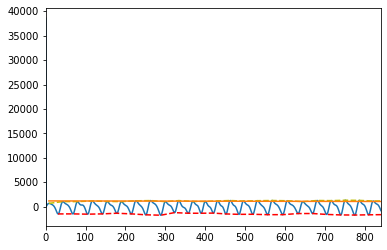

In [286]:
# two way works, one is actually using Python numpy and one is scipy stats module
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(peaks_positive, segment[peaks_positive])
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(peaks_positive, np.ones(len(peaks_positive)))

# plotting the upper envelope and lowe envelope
plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'--y')
plt.plot(peaks_negative,segment[peaks_negative],'--r')
plt.plot(peaks_positive,slope*peaks_positive+intercept)
print(r_value**2)
plt.xlim([0,840])
#plt.ylim([-7000,7000])
plt.show()

**make a for loop** for all the segments

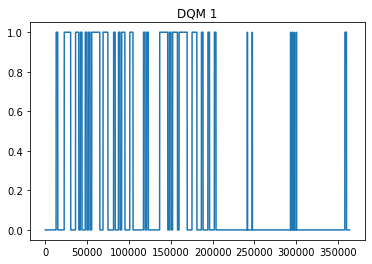

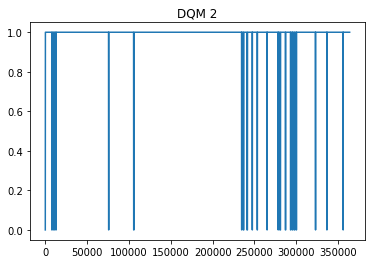

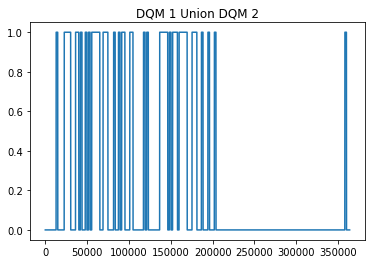

In [350]:
# this is the veru first Data Quality Metric (DQM#2) which is the volatility of the segment
# if the ratio of the max and min of the envelop is 0.5 and the less we assign number zero to that segment, 
# we will ignore it and treat it as not recorded signal

PPG_sample_freq = PPG_sample_freq.astype(int)

segment_length_threshold = 10*PPG_sample_freq
#DQM_signal =[]
DQM2_signal = np.zeros(1)
for kk in num_of_recording_segments:
  start_idx = collect_start_idx
  signal = red_filt_pyheart
  segment = signal[start_idx[kk-1]:start_idx[kk]]
  
 # if np.mean(segment) < 0.001:
  #  DQM2_segment_temp = np.zeros(collect_start_idx[kk]-collect_start_idx[kk-1])
   # print(len(DQM2_segment_temp))
    #DQM2_signal= np.append(DQM2_signal,DQM2_segment_temp)
    #continue

  peaks_positive, _ = find_peaks(segment, height=0,distance =20)
  peaks_negative, _ = find_peaks(-segment, height=0,distance =20)
  
  if len(peaks_negative) == 0:
    segment_highest_peak = 1000
    segment_lowest_peak = 1
    segment_highest_negative_peak = 1
    segment_lowest_negative_peak =100
  else:
    segment_highest_peak = np.amax(segment[peaks_positive])
    segment_lowest_peak = np.amin(segment[peaks_positive])
    segment_highest_negative_peak= np.amax(segment[peaks_negative])
    segment_lowest_negative_peak= np.amin(segment[peaks_negative])
  high_low_ratio_positive = segment_highest_peak/segment_lowest_peak
  high_low_ratio_negative = segment_highest_negative_peak/segment_lowest_negative_peak
  if high_low_ratio_positive > 5:
     #print('pos')
     DQM2_segment_temp = np.zeros(collect_start_idx[kk]-collect_start_idx[kk-1])
  elif high_low_ratio_negative<0.2:
     #print('neg')
     DQM2_segment_temp = np.zeros(collect_start_idx[kk]-collect_start_idx[kk-1])
  else: 
     DQM2_segment_temp = np.ones(collect_start_idx[kk]-collect_start_idx[kk-1])
  DQM2_signal= np.append(DQM2_signal,DQM2_segment_temp)

plt.figure()
plt.plot(DQM2_signal)

plt.title('DQM 1')
# zooming to the first recordings
plt.figure()
plt.plot(DQM_signal)
#plt.xlim([0,200000])
plt.title('DQM 2')

np.where(DQM2_signal<1)

plt.figure()
DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)
plt.plot(DQM_signal_all)
plt.title('DQM 1 Union DQM 2')

plt.show()
# convert zero to nan and then plot 

#now let's use this DQM into our HR prediction and then we will add more DQM_criteria

# Here I am calculting the slopes and the plotting those
An easy way to calculate the slope is just use the max peaks and the min peaks to identify the slope of the line by fitting using line regress. It might be time consuming but at this point we don’t need speed  scipy width of each peak 

58.66528911308576
Heart rate for the segment


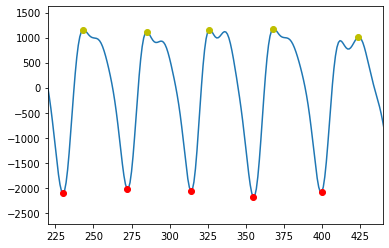

In [339]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
seg_number = 54
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([220,440])
#plt.ylim([-7000,7000])


time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

calucate the slopes using the max and minimum 




58.66528911308576
Heart rate for the segment


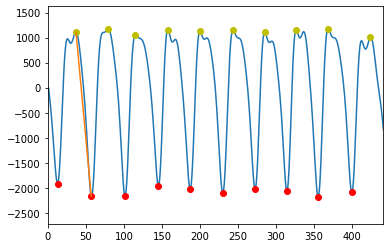

In [291]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
seg_number = 54
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,440])
#plt.ylim([-7000,7000])
 
slope_up_idx = [peaks_positive[0], peaks_negative[1]]
slope_up = [segment[peaks_positive[0]], segment[peaks_negative[1]]] 
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
slope_up_idx = np.array([peaks_positive[0], peaks_negative[1]])
slope_up = np.array([segment[peaks_positive[0]], segment[peaks_negative[1]]])
plt.plot(slope_up_idx,slope*slope_up_idx+intercept)

time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

using for loop to calculate all the slopes in the segment


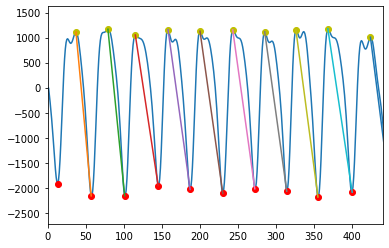

58.66528911308576
Heart rate for the segment


In [292]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
seg_number = 54
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,440])
#plt.ylim([-7000,7000])

for i in np.arange(1,len(peaks_positive)-1, 1):
  slope_up_idx = [peaks_positive[i-1], peaks_negative[i]]
  slope_up = [segment[peaks_positive[i-1]], segment[peaks_negative[i]]] 
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
  slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]])
  slope_up = np.array([segment[peaks_positive[i-1]], segment[peaks_negative[i]]])
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

now adding a for loop to calculate the slope for a short period after the peak and plot that:


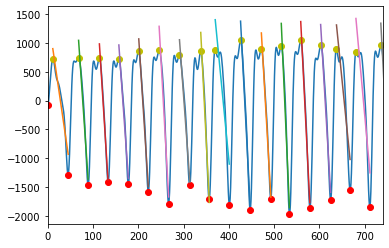

57.36161602168386
Heart rate for the segment


In [293]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):
seg_number = 56
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure()
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,740])
#plt.ylim([-7000,7000])

for i in np.arange(1,len(peaks_positive)-1, 1):
  slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
  slope_up = segment[slope_up_idx] 
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
  slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]])
  slope_up = np.array([segment[peaks_positive[i-1]], segment[peaks_negative[i]]])
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

Fixing the the peak point or the min point indexing in the for loop:


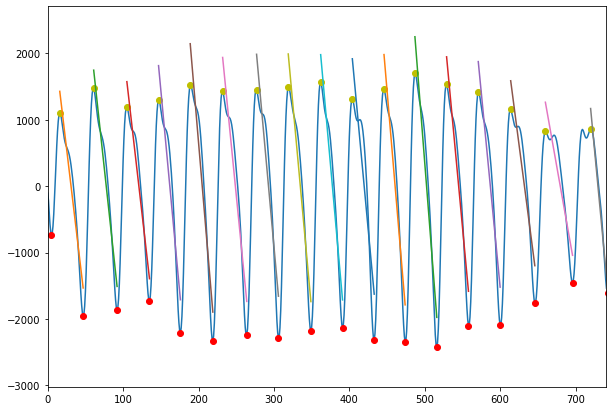

57.36161602168811
Heart rate for the segment


In [294]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 93
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(10,7))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,740])
#plt.ylim([-7000,7000])

for i in np.arange(1,len(peaks_positive)-1, 1):
  if peaks_positive[0]>peaks_negative[0]:
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]])
    slope_up = np.array([segment[peaks_positive[i-1]], segment[peaks_negative[i]]])
  elif peaks_positive[0]<peaks_negative[0]:
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i]])
    #converting the list to array and then plot
    slope_up = np.array([segment[peaks_positive[i]], segment[peaks_negative[i]]])
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

calculating first half part of the down slope and plotting the extended line

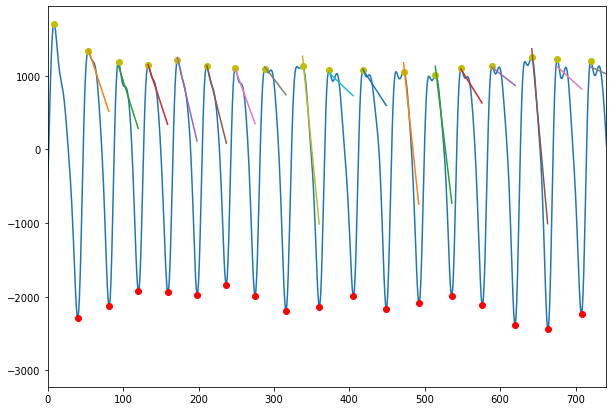

56.05794293028195
Heart rate for the segment


In [295]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 53
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(10,7))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,740])
#plt.ylim([-7000,7000])

for i in np.arange(1,len(peaks_positive)-1, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/2))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]])
    slope_up = np.array([segment[peaks_positive[i-1]], segment[peaks_negative[i]]])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/2))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i]])
    #converting the list to array and then plot
    slope_up = np.array([segment[peaks_positive[i]], segment[peaks_negative[i]]])
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

calculating first %25 part of the down slope and plotting without the extended slope 




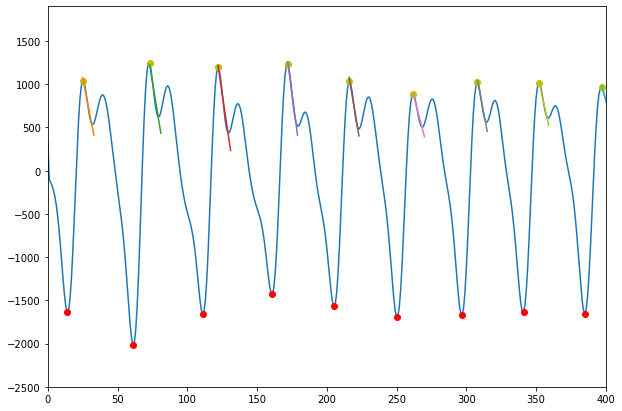

54.754269838884106
Heart rate for the segment


In [296]:
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 52
start_idx = collect_start_idx
signal = red_filt_pyheart
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(10,7))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,400])
plt.ylim([-2500,1900])

for i in np.arange(1,len(peaks_positive)-1, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

`applying the DQM1 mattrix for the length of the recorded segment - rejecting the short records`

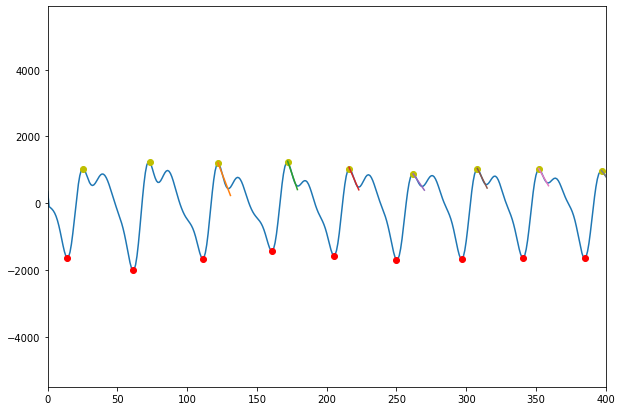

mean slope for the segment:
-59.896720496030696
54.754269838884106
Heart rate for the segment


In [311]:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 52
# here we multiply the the DQM1 to the data:
red_filt_pyheart_DQM1 = np.multiply(red_filt_pyheart,DQM_signal)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM1
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(10,7))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,400])
plt.ylim([-5500,5900])
slope_segment_temp = []
# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-4, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  slope_segment_temp  = np.append(slope_segment_temp,slope)
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
print('mean slope for the segment:')
print(np.mean(slope_segment_temp))
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

applying the DQM2 mattrix for the length of the recorded segment - rejecting the segments with volatile signal qualtiy records



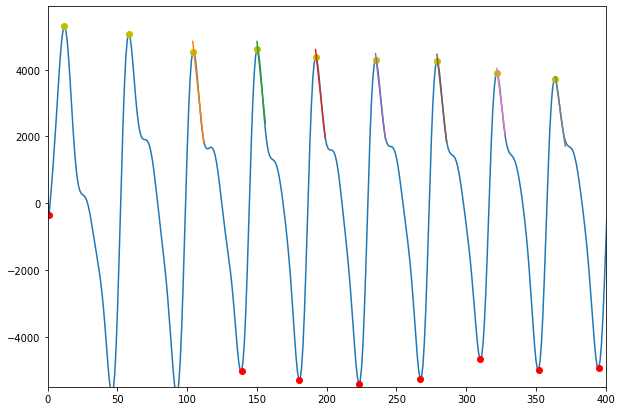

54.754269838882074
Heart rate for the segment


In [300]:
from numpy.core.defchararray import multiply
#segment plotter function
#def segment_plotter(seg_number,start_idx,signal):

seg_number = 45
# here we multiply the the DQM1 to the data:
#DQM_signal_all = np.multiply(DQM2_signal,DQM_signal)

red_filt_pyheart_DQM1 = np.multiply(red_filt_pyheart,DQM_signal)
start_idx = collect_start_idx
#signal = red_filt_pyheart
signal= red_filt_pyheart_DQM1
segment = signal[start_idx[seg_number-1]:start_idx[seg_number]]
peaks_positive, _ = find_peaks(signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)
peaks_negative, _ = find_peaks(-signal[start_idx[seg_number-1]:start_idx[seg_number]], height=0,distance =20)

plt.figure(figsize=(10,7))
plt.plot(signal[start_idx[seg_number-1]:start_idx[seg_number]])
plt.plot(peaks_positive,segment[peaks_positive],'oy')
plt.plot(peaks_negative,segment[peaks_negative],'or')

plt.xlim([0,400])
plt.ylim([-5500,5900])
# here we start from the third element of the segment to the last -4
for i in np.arange(3,len(peaks_positive)-4, 1):
  if peaks_positive[0]>peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i-1])/1.3))
    slope_up_idx = np.arange(peaks_positive[i-1], peaks_negative[i] - roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    #converting the list to array and then plot
    slope_up_idx = np.array([peaks_positive[i-1], peaks_negative[i]- roi_for_slopes])
  elif peaks_positive[0]<peaks_negative[0]:
    #slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i],1)
    roi_for_slopes = int(np.ceil((peaks_negative[i] - peaks_positive[i])/1.3))
    slope_up_idx = np.arange(peaks_positive[i], peaks_negative[i]- roi_for_slopes,1)
    slope_up = segment[slope_up_idx] 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(slope_up_idx, slope_up)
    slope_up_idx = np.array([peaks_positive[i], peaks_negative[i] - roi_for_slopes])
    #converting the list to array and then plot
  plt.plot(slope_up_idx,slope*slope_up_idx+intercept)
plt.show()
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')

# the envelope


In [ ]:
#from numpy.core.fromnumeric import std
#for the envelop of each segment, we just find the peak of the signal and the the reverse signal(signal multiplied * -1) which is basically the mean of the signal
upper_maxmin_segment_vector = np.zeros(recording_episode_counts_total+1)
lower_maxmin_segment_vector = np.zeros(recording_episode_counts_total+1)
upper_envelope_fluctuation =np.zeros(recording_episode_counts_total+1)
lower_envelope_fluctuation =np.zeros(recording_episode_counts_total+1)
for j in num_of_recording_segments:
  
  peaks_positive, _ = find_peaks(red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]], height=0,distance =20)
  peaks_negative, _ = find_peaks(-red_filt_pyheart[collect_start_idx[j-1]:collect_start_idx[j]], height=0,distance =20)
  
  if len(peaks_positive) == 0:
    continue
  if len(peaks_negative) == 0:
    continue
  mean_seg_postive_temp = np.mean(red_filt_pyheart[peaks_positive])
  max_seg_postive_temp = np.max(red_filt_pyheart[peaks_positive])
  min_seg_postive_temp = np.min(red_filt_pyheart[peaks_positive])
  std_seg_postive_temp = np.std(red_filt_pyheart[peaks_positive])
  mean_seg_negative_temp = np.mean(red_filt_pyheart[peaks_negative])
  max_seg_negative_temp = np.max(red_filt_pyheart[peaks_negative])
  min_seg_negative_temp = np.min(red_filt_pyheart[peaks_negative])
  std_seg_negative_temp = np.std(red_filt_pyheart[peaks_negative])
  upper_envelope_fluctuation[j]= std_seg_postive_temp
  lower_envelope_fluctuation[j] = std_seg_negative_temp
  upper_maxmin_segment_vector [j] = max_seg_postive_temp - min_seg_postive_temp
  lower_maxmin_segment_vector [j] =max_seg_negative_temp - min_seg_negative_temp
  #print(j)
  
# extracting the HR beat:
  #hr_interval = np.diff(time[peaks])
  #hr_interval_mean = np.mean(hr_interval)
  #print(time[peaks[-1]]-time[peaks[0]])
  #print(m)
 
  #print(time[peaks[-1]])
  #print(time[peaks[0]])

  #HR_ave [j] = len(peaks)/time_interval_in_min;
a = np.where(upper_envelope_fluctuation>2000)
b = np.where (lower_envelope_fluctuation>2000)
print(a)
print(b)

plt.figure()
plt.plot(upper_envelope_fluctuation, 'or')
plt.title('upper envelope')
plt.figure()
plt.plot(upper_maxmin_segment_vector,'xb')
plt.figure()
plt.title('lower envelope')
plt.plot(lower_envelope_fluctuation, 'or')
plt.figure()
plt.plot(lower_maxmin_segment_vector,'xb')


#print(upper_envelope_fluctuation)

In [ ]:
time_segment = time[start_idx[seg_number-1]:start_idx[seg_number]]
time_segment_length = time_segment[-1] - time_segment[0]
HR_mean_segment = len(peaks_positive)/time_segment_length
print(HR_mean_segment)
print('Heart rate for the segment')


In [ ]:
#from scipy.signal import resample

#resample the data. Usually 2, 4, or 6 times is enough depending on original sampling rate
resampled_data = resample(filtered, len(filtered) * 2)

Upsampling the signal has enabled HeartPy to optimize and find the position for all peaks in the signal.

Note the use of hp.scale_data() in the processing function. This is recommended when the amplitude is low (2.4-3.8 in the original data).

That works! A quick and dirty automatic extraction of signal sections
For this we use a window function and for each window test whether it:

Has a range that is at least 50% of range of the raw signal
OR
Has a maximum that is 90% the raw signal’s maximum
OR
Has a minimum that is the minimum + 10% of the raw signal
This works well enough